In [1]:
#imports

import h5py
import numpy as np
from scipy import stats
from scipy.stats import zscore
from matplotlib import pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, explained_variance_score
from sklearn.linear_model import RidgeCV
from sklearn.decomposition import PCA

import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [51]:
# Set Recording Session
year = '2024'
month = '09'
day = '23'

# Hyperparameters
model_type = 'model'
layer = 'conv402'
sh_limit = 0
monkey = 'West'
image_set = 'HvM'
category = None
min_repeat = 2

notes = 'Neuron on Self '

#set model_title

if model_type == 'model':
    model_title = f'Trained ResNet50 ({layer})'
elif model_type == 'rand':
    model_title = f'Untrained ResNet50 ({layer})'
elif model_type == 'barlow':
    model_title = f'Trained Barlow Model ({layer})'
elif model_type == 'model34':
    model_title = f'Trained ResNet34 ({layer})'
elif model_type == 'model18':
    model_title = f'Trained ResNet18 ({layer})'

hyperparameters = f'{notes}{model_title}, {image_set}, {min_repeat} reps, {year}{month}{day}'
folder = f'{monkey} {image_set} Figures'

trials_included = 10000

In [3]:
# Load data

marm_avg_spikes_t = np.load(f'./{year}_{month}_{day}/marm_avg_spikes_{year}{month}{day}.npy')
marm_avg_spikes = zscore(np.transpose(marm_avg_spikes_t.astype('float32')), axis=1)[:trials_included]

marm_avg_spikes_SHR_t = np.load(f'./{year}_{month}_{day}/marm_avg_spikes_SHR_{year}{month}{day}.npy')
marm_avg_spikes_SHR = zscore(np.transpose(marm_avg_spikes_SHR_t.astype('float32')), axis=1)[:trials_included]

marm_model_outputs_bad = np.load(f'./{year}_{month}_{day}/marm_{model_type}_{layer}outputs_{year}{month}{day}.npy')[:trials_included]
marm_model_outputs = zscore(marm_model_outputs_bad, axis=1)

print(marm_avg_spikes.shape)
print(marm_avg_spikes_SHR.shape)
print(marm_model_outputs.shape)

(859, 384)
(6859, 384)
(859, 25088)


In [4]:
# Load total data

if category == 'total':
    marm_avg_spikes_t = np.load(f'./{year}_{month}_{day}/marm_avg_spikes_total_{year}{month}{day}.npy')
    marm_avg_spikes = zscore(np.transpose(marm_avg_spikes_t.astype('float32')), axis=1)[:trials_included]
    
    marm_avg_spikes_SHR_t = np.load(f'./{year}_{month}_{day}/marm_avg_spikes_SHR_{year}{month}{day}.npy')
    marm_avg_spikes_SHR = zscore(np.transpose(marm_avg_spikes_SHR_t.astype('float32')), axis=1)[:trials_included]
    
    marm_model_outputs_bad = np.load(f'./{year}_{month}_{day}/marm_{model_type}_{layer}_outputs_avg_{year}{month}{day}.npy')[:trials_included]
    marm_model_outputs = zscore(marm_model_outputs_bad, axis=1)
    
    print(marm_avg_spikes.shape)
    print(marm_avg_spikes_SHR.shape)
    print(marm_model_outputs.shape)

In [5]:
# Load apple data

if category == 'apple':
    marm_avg_spikes_t = np.load(f'./{year}_{month}_{day}/marm_avg_spikes_apple_{year}{month}{day}.npy')
    marm_avg_spikes = zscore(np.transpose(marm_avg_spikes_t.astype('float32')), axis=1)[:trials_included]
    
    marm_avg_spikes_SHR_t = np.load(f'./{year}_{month}_{day}/marm_avg_spikes_SHR_{year}{month}{day}.npy')
    marm_avg_spikes_SHR = zscore(np.transpose(marm_avg_spikes_SHR_t.astype('float32')), axis=1)[:trials_included]
    
    marm_model_outputs_bad = np.load(f'./{year}_{month}_{day}/marm_{model_type}_{layer}_apple_outputs_{year}{month}{day}.npy')[:trials_included]
    marm_model_outputs = zscore(marm_model_outputs_bad, axis=1)
    
    print(marm_avg_spikes.shape)
    print(marm_avg_spikes_SHR.shape)
    print(marm_model_outputs.shape)

In [6]:
# load and test neural

neural_tot = marm_avg_spikes
neural_dim = marm_avg_spikes.shape[1]

print("neural min:", neural_tot.min())
print("neural max:", neural_tot.max())
print("neural mean:", neural_tot.mean())
print("neural std:", neural_tot.std())

neural_tot.shape

neural min: -1.1461624
neural max: 9.094078
neural mean: 5.392058e-09
neural std: 1.0


(859, 384)

In [7]:
# load and test model outputs

model_tot = marm_model_outputs

print("outputs min:", model_tot.min())
print("outputs max:", model_tot.max())
print("outputs mean:", model_tot.mean())
print("outputs std:", model_tot.std())

model_tot.shape

outputs min: -11.903035
outputs max: 10.063609
outputs mean: 1.4514923e-10
outputs std: 0.9999995


(859, 25088)

In [8]:
# Subset of model outputs

model_outputs_dim = 305

rand_idx = np.arange(model_tot.shape[1])
np.random.shuffle(rand_idx)
subset_idx = rand_idx[:model_outputs_dim]

subset_outputs = model_tot[:, subset_idx]

subset_outputs.shape

(859, 305)

In [9]:
# make new indices for SHR
ch_tot = marm_avg_spikes.shape[1]
stim_tot = marm_avg_spikes.shape[0]
indices = np.arange(stim_tot)

In [10]:
# load natimg_path_list # !!!!!!!NOTE CHANGED THIS TO NOT SHR!!!!!!!

with open(f'./{year}_{month}_{day}/natimg_path_list_SHR_{year}{month}{day}', 'rb') as fp:   # Unpickling
    natimg_path_list = pickle.load(fp)

natimg_path_list = natimg_path_list[:trials_included]
len(natimg_path_list)

6859

In [11]:
# get max_reps

trial_counts = []

for path in set(natimg_path_list):
    trial_counts.append(natimg_path_list.count(path))

max_reps = max(trial_counts)

print(max_reps)

21


In [12]:
# Check when choosing min reps

for reps in range(0, max_reps+1, 2):
    print(f'Min Reps: {reps}, Images: {len([x for x in trial_counts if x>=reps])}')

Min Reps: 0, Images: 450
Min Reps: 2, Images: 450
Min Reps: 4, Images: 450
Min Reps: 6, Images: 450
Min Reps: 8, Images: 450
Min Reps: 10, Images: 450
Min Reps: 12, Images: 441
Min Reps: 14, Images: 383
Min Reps: 16, Images: 202
Min Reps: 18, Images: 40
Min Reps: 20, Images: 2


In [13]:


#What? How?



In [14]:
# HVM: Get demon matrix for each neuron

many_path_list = [path for path in natimg_path_list 
                      if natimg_path_list.count(path) >= min_repeat] # WHAT??????????????????????
img_count = len(set(many_path_list))
sh_data = np.zeros(ch_tot)
img_spikes_tot = np.zeros((ch_tot, max_reps, img_count))

for ch in range(ch_tot):
    neuron = marm_avg_spikes_SHR[:, ch]
    count_arr = np.zeros((max_reps, img_count))
    count_arr[:] = np.nan
    for i, path in enumerate(set(many_path_list)):
        idx_list = [i for i, j in enumerate(natimg_path_list) if j == path]
        # note: original mistake, ^ should take natimg_path_list as arg
        for rep, idx in enumerate(idx_list):
            count_arr[rep, i] = neuron[idx]
    img_spikes_tot[ch] = count_arr
    neuron_1, neuron_2 = count_arr[::2], count_arr[1::2]
    neuron_1_avg = np.nanmean(neuron_1, axis=0)
    neuron_2_avg = np.nanmean(neuron_2, axis=0)
    sh, _ = stats.pearsonr(neuron_1_avg, neuron_2_avg)
    sh_data[ch] = sh

In [52]:
# Get good idx
good_idx = np.where(sh_data >= sh_limit)[0]

# get good sh, exp
good_sh = sh_data[good_idx]

good_ch_tot = good_idx.shape[0]

print(f'Number of good neurons: {good_ch_tot}')

Number of good neurons: 263


In [53]:
# Create indices
folds = 3
indices = np.arange(stim_tot)

indices_list = []
for i in range(folds):
    train_indices, test_indices = train_test_split(indices, test_size = .5)
    train_indices = np.sort(train_indices)
    test_indices = np.sort(test_indices)
    indices_set = [train_indices, test_indices]
    indices_list.append(indices_set)

#test_indices = np.load('/Users/parsatalaie/Desktop/Marmoset Data Analysis/marm_even_test_trial_idx.npy').astype(int)
#train_indices = np.delete(n_train_indices, test_indices)

In [54]:
# prepare for loop cv

scores_tot = np.zeros((folds, good_ch_tot))
alphas_tot = np.zeros((folds, good_ch_tot))
exp_data_tot = np.zeros((folds, good_ch_tot))
corr_data_tot = np.zeros((folds, good_ch_tot))
lr_outputs_np_tot = np.zeros((folds, indices_list[0][1].shape[0], good_ch_tot))
print(lr_outputs_np_tot.shape)

(3, 430, 263)


In [55]:
# Check for number of components
max_components = min(model_tot.shape[1]//2, model_tot.shape[0])

for i in range(50, max_components, 50):
    pca = PCA(n_components = i)
    pca.fit(model_tot)
    print(f'{i} : {pca.explained_variance_ratio_.sum() * 100:.4f}')
    if pca.explained_variance_ratio_.sum() >= 1:
        break

50 : 89.4519
100 : 95.1082
150 : 97.3840
200 : 98.5451
250 : 99.1994
300 : 99.5851
350 : 99.8131
400 : 99.9445
450 : 100.0028


In [52]:
# Set components
num_comps = 450

pca = PCA(n_components = num_comps)
pca_outputs = pca.fit_transform(model_tot)
pca.explained_variance_ratio_.sum()

1.0000219

In [56]:
pca_outputs = marm_avg_spikes
pca_outputs.shape

(859, 384)

In [57]:
# for loop regression
'''
alphas_list = [.01, .02, .05, .1, .5, 1, 5, 10, 50, 100, 500, 1000, 2500, 5000,
               10000, 25000, 50000, 100000, 500000]
'''
alphas_list = [.01, .02, .05, .1, .5, 1, 5, 10]


for fold, tt_idx in enumerate(indices_list):
    train_indices, test_indices = tt_idx[0], tt_idx[1]
    
    predictions = np.zeros((test_indices.shape[0], good_ch_tot))
    scores = np.zeros(good_ch_tot)
    alphas = np.zeros(good_ch_tot)
    
    for i in range(good_ch_tot):
        neuron = marm_avg_spikes[:, good_idx[i]]
        model = RidgeCV(alphas=alphas_list).fit(pca_outputs[train_indices], neuron[train_indices])
        synth_neuron = model.predict(pca_outputs[test_indices])
        predictions[:, i] = synth_neuron
        scores[i] = model.score(pca_outputs[train_indices], neuron[train_indices])
        alphas[i] = model.alpha_

    lr_outputs_np_tot[fold] = predictions

    # Check scores
    scores_tot[fold] = scores

    # Check alphas
    alphas_tot[fold] = alphas
    
    for i in range(good_ch_tot):
        neuron = marm_avg_spikes[:, good_idx[i]]
        y = r2_score(neuron[test_indices], predictions[:, i])
        z, _ = stats.pearsonr(neuron[test_indices], predictions[:, i])
        exp_data_tot[fold, i] = y
        corr_data_tot[fold, i] = z
    
    # Individual Explained Variance
    exp_var = r2_score(marm_avg_spikes[test_indices, :][:, good_idx], predictions)
    print(f"Explained Variance of the model: {100*exp_var:.2f}%")

Explained Variance of the model: 99.95%
Explained Variance of the model: 99.93%
Explained Variance of the model: 99.95%


In [58]:
# Check alphas

for i in alphas_list:
    print(f'{i} : {np.where(alphas_tot == i)[0].shape[0]}')

0.01 : 789
0.02 : 0
0.05 : 0
0.1 : 0
0.5 : 0
1 : 0
5 : 0
10 : 0


In [59]:
# Get good_exp, good_corr

good_exp = exp_data_tot.mean(axis = 0)
good_corr = corr_data_tot.mean(axis = 0)
good_corr.shape

(263,)

In [60]:
# Set metric, model_title

eval = 'r'

if eval == 'r':
    metric = good_corr
    y_label = 'Correlation of model output, neuron'
    title = 'Correlation vs SHR'
    eval_scores = np.sqrt(scores_tot)
elif eval == 'R^2':
    metric = good_exp
    y_label = 'Explained Variance by model'
    title = 'ExpVar vs SHR'
    eval_scores = scores_tot

print(eval)

r


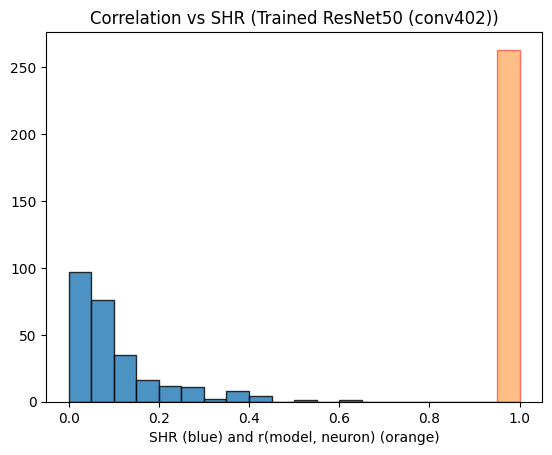

In [61]:
# Create histogram for SHR
set_bins = np.arange(21)*.05
plt.hist(good_sh, bins = set_bins, edgecolor = 'black', alpha = .8)
plt.hist(good_corr, bins = set_bins, edgecolor = 'red', alpha = .5)
plt.title(f'{title} ({model_title})')
plt.xlabel(f'SHR (blue) and {eval}(model, neuron) (orange)')
plt.show()

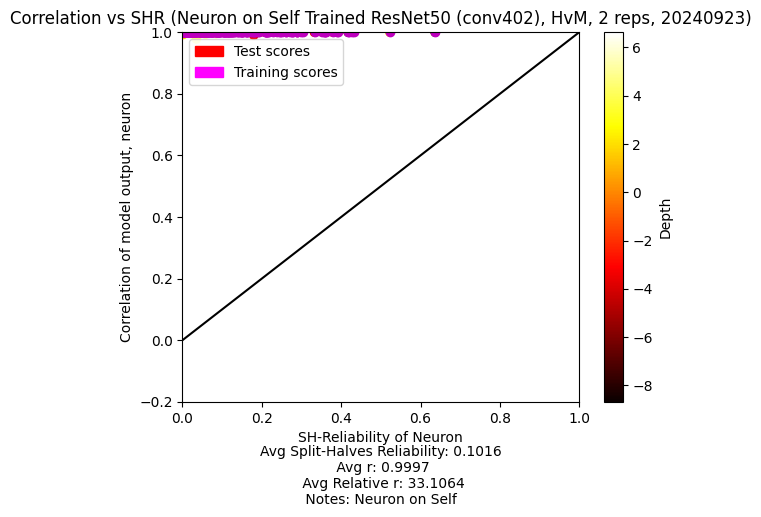

In [62]:
# Create plot

# Colors
ch_depth = np.load(f'./{year}_{month}_{day}/ch_depth_{year}{month}{day}.npy')

# Plot
scatter = plt.scatter(
    good_sh, metric, c = ch_depth[good_idx], cmap = 'hot')
plt.title(f'{title} ({hyperparameters})')
plt.ylabel(y_label)
plt.xlabel('SH-Reliability of Neuron')

#colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Depth')

# Additional
plt.axline((0, 0), slope=1, c='k')
scatter = plt.scatter(
    good_sh, eval_scores.mean(axis=0), c = 'm')
r_patch = mpatches.Patch(color='red', label = 'Test scores')
m_patch = mpatches.Patch(color='magenta', label = 'Training scores')
plt.legend(handles = [r_patch, m_patch], loc = "upper left")

# Set X-axis
ax = plt.gca()
ax.set_xlim([0, 1])
ax.set_ylim([-.2, 1])

# Add caption
r, p = stats.pearsonr(good_sh, metric)
relative_exp = metric / (2 * good_sh / (1 + good_sh))

plt.text(0.5, -0.2, f'Avg Split-Halves Reliability: {good_sh.mean():.4f}'
         f'\n Avg {eval}: {metric.mean():.4f}'
         f'\n Avg Relative {eval}: {relative_exp.mean():.4f}'
         f'\n Notes: {notes}',
         horizontalalignment='center',
         verticalalignment='center', transform=ax.transAxes)

# Save plot
plt.savefig(f'/Users/parsatalaie/Desktop/{folder}/{hyperparameters}', bbox_inches='tight')

# Show the plot
plt.show()

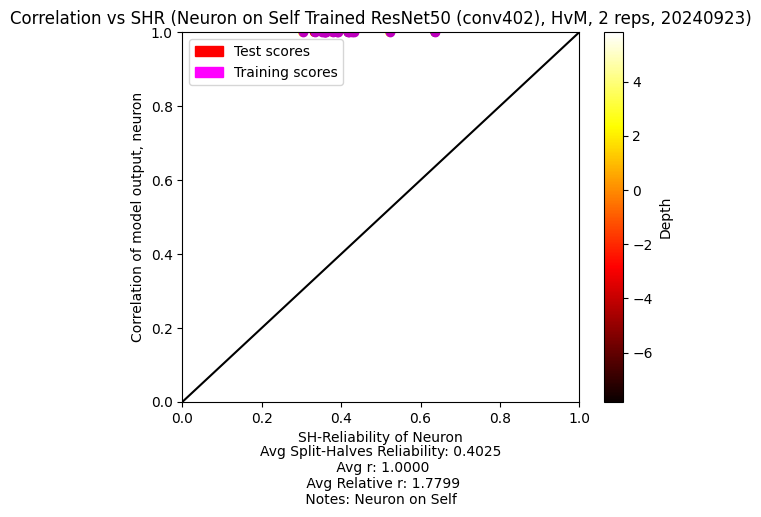

In [50]:
# Save it

# Create plot

# Colors
ch_depth = np.load(f'./{year}_{month}_{day}/ch_depth_{year}{month}{day}.npy')

# Plot
scatter = plt.scatter(
    good_sh, metric, c = ch_depth[good_idx], cmap = 'hot')
plt.title(f'{title} ({hyperparameters})')
plt.ylabel(y_label)
plt.xlabel('SH-Reliability of Neuron')

#colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Depth')

# Additional
plt.axline((0, 0), slope=1, c='k')
scatter = plt.scatter(
    good_sh, eval_scores.mean(axis=0), c = 'm')
r_patch = mpatches.Patch(color='red', label = 'Test scores')
m_patch = mpatches.Patch(color='magenta', label = 'Training scores')
plt.legend(handles = [r_patch, m_patch], loc = "upper left")

# Set X-axis
ax = plt.gca()
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

# Add caption
r, p = stats.pearsonr(good_sh, metric)
relative_exp = metric / (2 * good_sh / (1 + good_sh))

plt.text(0.5, -0.2, f'Avg Split-Halves Reliability: {good_sh.mean():.4f}'
         f'\n Avg {eval}: {metric.mean():.4f}'
         f'\n Avg Relative {eval}: {relative_exp.mean():.4f}'
         f'\n Notes: {notes}',
         horizontalalignment='center',
         verticalalignment='center', transform=ax.transAxes)

# Save plot
plt.savefig(f'/Users/parsatalaie/Desktop/{folder}/{hyperparameters}', bbox_inches='tight')

In [38]:
# Aggregate all responses, linreg into one dict
resp_dict = {'IT Data': neural_tot[:, good_idx][indices_list[0][1]], 'Model Output': lr_outputs_np_tot[0]}

resp_dict['IT Data'].shape

(430, 16)

In [39]:
neural_tot.shape

(859, 384)

In [40]:
pca_outputs.shape

(859, 16)

In [41]:
# Aggregate all responses, linreg into one dict
resp_dict = {'IT Data': neural_tot[:, good_idx][indices_list[0][1]], 
             'Model Output': pca_outputs[indices_list[0][1]]}

resp_dict['IT Data'].shape

(430, 16)

In [42]:
resp_dict['Model Output'].shape

(430, 16)

In [43]:
# Plotting Functions

def show_stimulus(img, ax=None, show=False):
  """Visualize a stimulus"""
  if ax is None:
    ax = plt.gca()
  ax.imshow(img, cmap=mpl.cm.binary)
  ax.set_aspect('auto')
  ax.set_xticks([])
  ax.set_yticks([])
  ax.spines['left'].set_visible(False)
  ax.spines['bottom'].set_visible(False)
  if show:
    plt.show()


def plot_corr_matrix(rdm, ax=None, show=False):
  """Plot dissimilarity matrix

  Args:
    rdm (numpy array): n_stimuli x n_stimuli representational dissimilarity
      matrix
    ax (matplotlib axes): axes onto which to plot

  Returns:
    nothing

  """
  if ax is None:
    ax = plt.gca()
  image = ax.imshow(rdm, vmin=0.0, vmax=2.0)
  ax.set_xticks([])
  ax.set_yticks([])
  cbar = plt.colorbar(image, ax=ax, label='dissimilarity')
  if show:
    plt.show()


def plot_multiple_rdm(rdm_dict):
  """Draw multiple subplots for each RDM in rdm_dict."""
  fig, axs = plt.subplots(1, len(rdm_dict),
                          figsize=(4 * len(resp_dict), 3.5))

  # Compute RDM's for each set of responses and plot
  for i, (label, rdm) in enumerate(rdm_dict.items()):

    image = plot_corr_matrix(rdm, axs[i])
    axs[i].set_title(label)

def plot_rdm_rdm_correlations(rdm_sim):
  """Draw a bar plot showing between-RDM correlations."""
  f, ax = plt.subplots()
  ax.bar(rdm_sim.keys(), rdm_sim.values())
  ax.set_xlabel('Deep network model layer')
  ax.set_ylabel('Correlation of model layer RDM\nwith IT Data')
  plt.show()


def plot_rdm_rows(ori_list, rdm_dict, rdm_oris):
  """Plot the dissimilarity of response to each stimulus with response to one
  specific stimulus

  Args:
    ori_list (list of float): plot dissimilarity with response to stimulus with
      orientations closest to each value in this list
    rdm_dict (dict): RDM's from which to extract dissimilarities
    rdm_oris (np.ndarray): orientations corresponding to each row/column of RDMs
    in rdm_dict

  """
  n_col = len(ori_list)
  f, axs = plt.subplots(1, n_col, figsize=(4 * n_col, 4), sharey=True)

  # Get index of orientation closest to ori_plot
  for ax, ori_plot in zip(axs, ori_list):
    iori = np.argmin(np.abs(rdm_oris - ori_plot))

    # Plot dissimilarity curves in each RDM
    for label, rdm in rdm_dict.items():
      ax.plot(rdm_oris, rdm[iori, :], label=label)

    # Draw vertical line at stimulus we are plotting dissimilarity w.r.t.
    ax.axvline(rdm_oris[iori], color=".7", zorder=-1)

    # Label axes
    ax.set_title(f'Dissimilarity with response\nto {ori_plot: .0f}$^o$ stimulus')
    ax.set_xlabel('Stimulus orientation ($^o$)')

  axs[0].set_ylabel('Dissimilarity')
  axs[-1].legend(loc="upper left", bbox_to_anchor=(1, 1))
  plt.tight_layout()
  plt.show()

In [44]:
# Define correlate_rdms
def correlate_rdms(rdm1, rdm2):
    """Correlate off-diagonal elements of two RDM's
  
    Args:
      rdm1 (np.ndarray): S x S representational dissimilarity matrix
      rdm2 (np.ndarray): S x S representational dissimilarity matrix to
        correlate with rdm1
  
    Returns:
      float: correlation coefficient between the off-diagonal elements
        of rdm1 and rdm2
  
    """
  
    # Extract off-diagonal elements of each RDM
    ioffdiag = np.triu_indices(rdm1.shape[0], k=1)  # indices of off-diagonal elements
    rdm1_offdiag = rdm1[ioffdiag]
    rdm2_offdiag = rdm2[ioffdiag]
  
    corr_coef = np.corrcoef(rdm1_offdiag, rdm2_offdiag)[0,1]
  
    return corr_coef

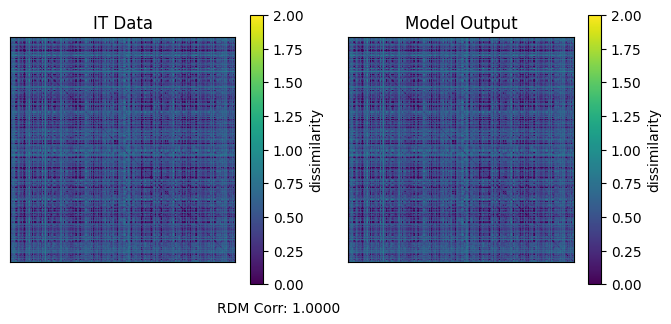

In [45]:
# RDM def and plot

def RDM(resp):
    """Compute the representational dissimilarity matrix (RDM)
  
    Args:
      resp (ndarray): S x N matrix with population responses to
        each stimulus in each row
  
    Returns:
      ndarray: S x S representational dissimilarity matrix
    """
  
    # z-score responses to each stimulus
    zresp = resp #zscore(resp, axis=1)
  
    # Compute RDM
    RDM = 1 - (zresp @ zresp.T) / zresp.shape[1]
    return RDM


# Compute RDMs for each layer
rdm_dict = {label: RDM(resp) for label, resp in resp_dict.items()}

# Plot RDMs
plot_multiple_rdm(rdm_dict)

# Correlate RDMs

# Split RDMs into V1 responses and model responses
rdm_model = rdm_dict.copy()
rdm_IT = rdm_model.pop('IT Data')

# Correlate off-diagonal terms of dissimilarity matrices
rdm_sim = {label: correlate_rdms(rdm_IT, rdm) for label, rdm in rdm_model.items()}

plt.text(0.5, -0.1, f'RDM Corr: {rdm_sim['Model Output']:.4f}',
         horizontalalignment='center',
         verticalalignment='center', transform=ax.transAxes)

plt.savefig(f'/Users/parsatalaie/Desktop/{folder}/{hyperparameters} RDM', bbox_inches='tight')

plt.show()

In [24]:
# Get demon matrix for each model output feature
img_model_tot = np.zeros((model_outputs_dim, max_reps, img_count))

for ch in range(model_outputs_dim):
    neuron = subset_outputs[:, ch]
    count_arr = np.zeros((max_reps, img_count))
    count_arr[:] = np.nan
    for i in range(img_count):
        path = f'/Users/parsatalaie/Downloads/rust_natimgs/Nat300_{i+1}.png'
        idx_list = [i for i, j in enumerate(natimg_path_list) if j == path]
        for rep, idx in enumerate(idx_list):
            count_arr[rep, i] = neuron[idx]
    img_model_tot[ch] = count_arr

In [ ]:
# Garbage Adam LR
class LinearRegression(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
    
    def forward(self, x):
        return self.linear(x)

input_dim = model_outputs_dim       # takes variable 'x' 
output_dim = neural_dim       # takes variable 'y'
learning_rate = 0.01 
epochs = 1000

linreg = LinearRegression(input_dim, output_dim)  # n input features
criterion = nn.MSELoss()
optimizer = optim.Adam(linreg.parameters(), lr=learning_rate, weight_decay=0)

inputs = subset_outputs
labels = neural_tot

for epoch in range(epochs):
    # Converting inputs and labels to Variable

    # Clear gradient buffers because we don't want any gradient from previous epoch to carry forward, dont want to cummulate gradients
    optimizer.zero_grad()

    # get output from the model, given the inputs
    outputs = linreg(inputs)

    # get loss for the predicted output
    loss = criterion(outputs, labels)
    # get gradients w.r.t to parameters
    loss.backward()

    # update parameters
    optimizer.step()

    #print('epoch {}, loss {}'.format(epoch, loss.item()))

# Create og lr_outputs_np

lr_outputs = linreg(subset_outputs)
lr_outputs_np = lr_outputs.detach().cpu().numpy()